# 1. Data Loading and Preprocessing

In [6]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Load data from Yahoo Finance (Upload your CSV file)
from google.colab import drive
drive.mount('/content/drive')

# Read CSV file into DataFrame and set 'Date' as index
DJIA_path = '/content/drive/MyDrive/FINAL PROJECT/DJIA_table(train).csv'
data = pd.read_csv(DJIA_path, index_col='Date', parse_dates=True)

# Sort the data by date in ascending order
data = data.sort_index(ascending=True)

# Keep only the 'Close' price column
data = data[['Close']]

# Check for null values and fill if needed
data = data.fillna(method='ffill')

# Display the first few rows of the data
data.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<ipython-input-6-ffa4df8e791c>:13: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  data = pd.read_csv(DJIA_path, index_col='Date', parse_dates=True)
<ipython-input-6-ffa4df8e791c>:22: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.fillna(method='ffill')


,Close
Date,
2008-08-08,11734.32031
2008-08-11,11782.34961
2008-08-12,11642.46973
2008-08-13,11532.95996
2008-08-14,11615.92969


# 2. Data Normalization

In [7]:
# Normalize the 'Close' price using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Display the scaled data
print(scaled_data[:5])

[[0.4408942 ]
 [0.44497647]
 [0.43308732]
 [0.42377949]
 [0.43083154]]


# 3. Creating Training and Testing Data

In [8]:
# Define look-back period (number of previous days to use as input)
look_back = 60  # For example, use 60 previous days to predict the next day

# Split data into training and testing sets (80% for training)
train_size = int(len(scaled_data) * 0.8)
train_data, test_data = scaled_data[:train_size], scaled_data[train_size - look_back:]

# Function to create dataset for LSTM model
def create_dataset(data, look_back):
    X, y = [], []
    for i in range(look_back, len(data)):
        X.append(data[i - look_back:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

# Create training and testing datasets
X_train, y_train = create_dataset(train_data, look_back)
X_test, y_test = create_dataset(test_data, look_back)

# Reshape input data for LSTM (samples, time steps, features)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Display the shape of the training and testing sets
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

X_train shape: (1430, 60, 1)
X_test shape: (373, 60, 1)


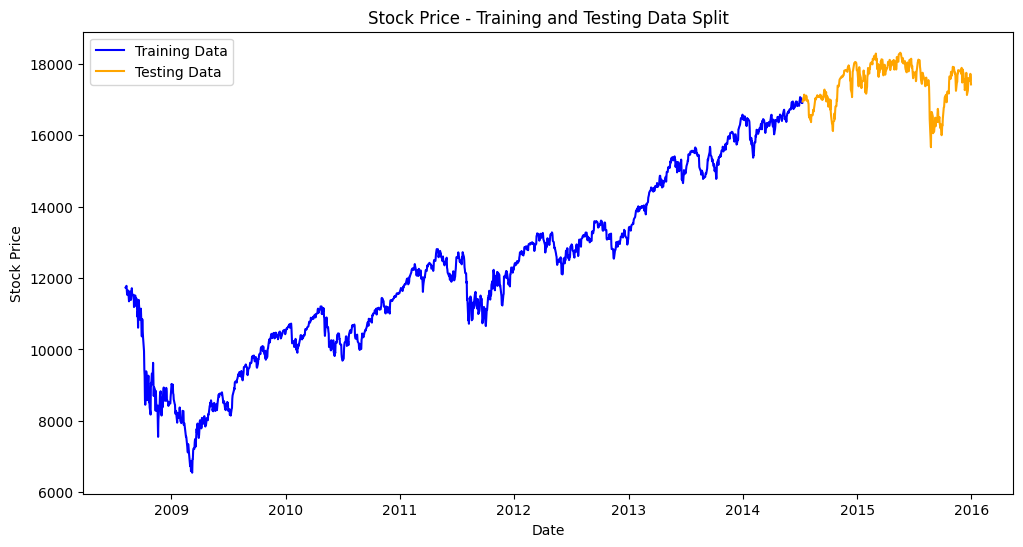

In [9]:
import matplotlib.pyplot as plt

# Separate original data into training and testing sets
train_data_len = len(X_train) + look_back  # Length of training data including look-back
train = data[:train_data_len]  # Training set (based on original data length)
test = data[train_data_len:]   # Testing set (based on original data length)

# Plot the training and testing data with different colors
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['Close'], label='Training Data', color='blue')  # Training data in blue
plt.plot(test.index, test['Close'], label='Testing Data', color='orange')   # Testing data in orange

# Add labels and title
plt.title("Stock Price - Training and Testing Data Split")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.legend()
plt.show()

# 4. Building the LSTM Model

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

# Initialize the LSTM model
model = Sequential()

# Add LSTM and Dropout layers
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Display the model summary
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 60, 50)              │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 60, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 25)                  │           1,275 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              26 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,901 (124.61 KB)

 Trainable params: 31,901 (124.61 KB)

 Non-trainable params: 0 (0.00 B)

# 5. Training the Model

Epoch 1/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 6s 73ms/step - loss: 0.0423 - val_loss: 0.0215
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - loss: 0.0036 - val_loss: 5.9176e-04
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - loss: 0.0024 - val_loss: 4.1160e-04
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - loss: 0.0021 - val_loss: 4.1941e-04
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - loss: 0.0018 - val_loss: 4.0356e-04
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 86ms/step - loss: 0.0017 - val_loss: 7.5987e-04
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - loss: 0.0016 - val_loss: 6.3785e-04
Epoch 8/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - loss: 0.0016 - val_loss: 6.1648e-04
Epoch 9/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - loss: 0.0014 - val_loss: 3.8079e-04
Epoch 10/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - loss: 0.0012 - val_loss: 4.5384e-04
Epoch 11/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 90ms/step - loss: 0.0014 - val_loss: 7.1324e-04
Epoch 12/50
36/36 ━━━━━

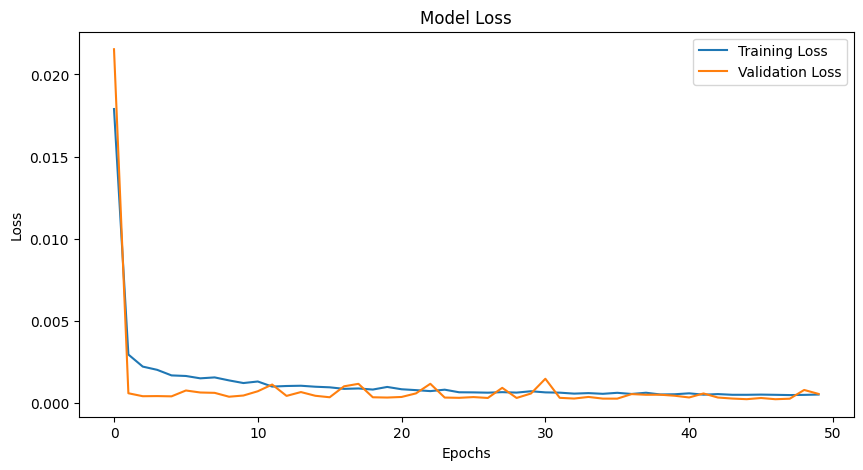

In [11]:
# Train the model on the training data with validation on a portion of it
history = model.fit(X_train, y_train, batch_size=32, epochs=50, validation_split=0.2)

# Plot training and validation loss over epochs
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 6. Making Predictions and Evaluating Model Performance

In [12]:
from sklearn.metrics import mean_squared_error
from math import sqrt

# Make predictions
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

# Inverse transform the predictions and actual values
train_predictions = scaler.inverse_transform(train_predictions)
y_train_inv = scaler.inverse_transform([y_train])
test_predictions = scaler.inverse_transform(test_predictions)
y_test_inv = scaler.inverse_transform([y_test])

# Calculate RMSE for training and testing predictions
train_rmse = sqrt(mean_squared_error(y_train_inv[0], train_predictions[:,0]))
test_rmse = sqrt(mean_squared_error(y_test_inv[0], test_predictions[:,0]))

print(f'Train RMSE: {train_rmse}')
print(f'Test RMSE: {test_rmse}')

45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Train RMSE: 225.90770023313286
Test RMSE: 383.4150851995183


# 7. Plotting Predictions vs Actual Values

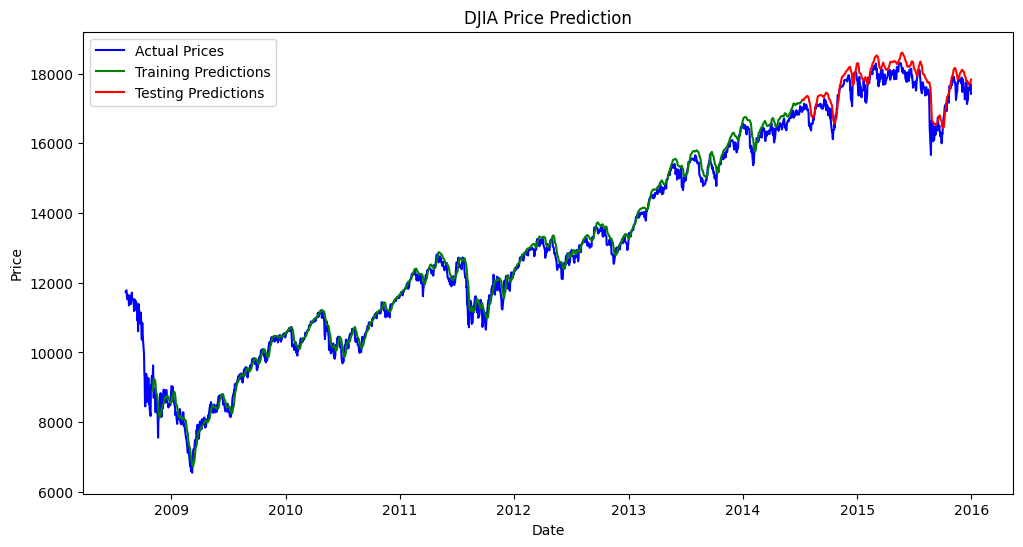

In [16]:
# Correct the date indices for the training and testing predictions
train_dates = data.index[look_back:look_back + len(train_predictions)]
test_dates = data.index[look_back + len(train_predictions):look_back + len(train_predictions) + len(test_predictions)]

# Plot actual data
plt.figure(figsize=(12, 6))
plt.plot(data.index, scaler.inverse_transform(scaled_data), label='Actual Prices', color='blue')

# Plot training predictions
plt.plot(train_dates, train_predictions, label='Training Predictions', color='green')

# Plot testing predictions
plt.plot(test_dates, test_predictions, label='Testing Predictions', color='red')

# Plot details
plt.title('DJIA Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()